In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline
#paths to the train, validation and test image datasets
train_path = '/content/drive/MyDrive/text-data/Garbage classification'
valid_path = '/content/drive/MyDrive/text-data/Garbage classification'

IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_batches = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training',seed=42)


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.inception_resnet_v2.preprocess_input  ,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='validation',seed=42)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [ ]:
# Training set
num_train_batches = len(train_batches)
X_train, Y_train = [], []

for i in range(num_train_batches):
    data = train_batches.next()
    X_train.append(data[0])
    Y_train.append(data[1])

X_train = np.concatenate(X_train)
Y_train = np.concatenate(Y_train)

# Validation set
num_valid_batches = len(valid_batches)
X_test, Y_test = [], []

for i in range(num_valid_batches):
    data = valid_batches.next()
    X_test.append(data[0])
    Y_test.append(data[1])

X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)


In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_output1=base_model.get_layer('conv_pw_13_relu').output
#inp= model_mobileNet.layers[-4].output
out=tf.keras.layers.GlobalAveragePooling2D()(base_output1)
model = tf.keras.models.Model(inputs=base_model.input, outputs=out)

# Extract features using the pre-trained model
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

8/8 [==============================] - 1s 138ms/step


In [ ]:

# Flatten the extracted features
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)
X_train =X_train_features
X_test = X_test_features

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [ ]:
Y_train=np.argmax(Y_train, axis=1)
Y_test=np.argmax(Y_test, axis=1)

In [ ]:
# Train SVM classifier with selected features
clf = SVC()
clf.fit(X_train_features, Y_train)

y_pred = clf.predict(X_train_features)
accuracy = accuracy_score(Y_train, y_pred)

print("Accuracy on Train Set:", accuracy)
# Evaluate on the test set
y_pred = clf.predict(X_test_features)
accuracy = accuracy_score(Y_test, y_pred)

print("Accuracy on Test Set:", accuracy)

Accuracy on Train Set: 0.9753954305799648
Accuracy on Test Set: 0.8645418326693227


In [ ]:
class GeneticAlgorithm:
    def __init__(self, population_size, n_features, crossover_prob=0.8, mutation_prob=0.2, generations=5):
        self.population_size = population_size
        self.n_features = n_features
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.generations = generations

    def initialize_population(self):
        return np.random.randint(2, size=(self.population_size, self.n_features))

    def evaluate_population(self, population, X_train, y_train):
        accuracies = []
        for solution in population:
            selected_features = np.where(solution == 1)[0]
            if len(selected_features) == 0:
                accuracies.append(0.0)
                continue

            clf = SVC()
            clf.fit(X_train[:, selected_features], y_train)
            accuracy = accuracy_score(y_train, clf.predict(X_train[:, selected_features]))
            accuracies.append(accuracy)

        return np.array(accuracies)

    def select_parents(self, population, fitness):
        # Tournament selection
        selected_indices = np.random.choice(self.population_size, size=(2, self.population_size), replace=True)
        selected_parents = population[selected_indices[np.argmax(fitness[selected_indices], axis=0), np.arange(self.population_size)]]
        return selected_parents

    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, self.n_features)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2

    def mutate(self, child):
        mutation_mask = np.random.rand(self.n_features) < self.mutation_prob
        child[mutation_mask] = 1 - child[mutation_mask]
        return child

    def run(self, X_train, y_train):
        population = self.initialize_population()

        for generation in range(self.generations):
            fitness = self.evaluate_population(population, X_train, y_train)

            parents = self.select_parents(population, fitness)

            # Create offspring through crossover so we get the new population
            offspring = []
            for i in range(0, self.population_size, 2):
                if np.random.rand() < self.crossover_prob:
                    child1, child2 = self.crossover(parents[i], parents[i + 1])
                else:
                    child1, child2 = parents[i], parents[i + 1]

                # Mutate children for the new generation
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                offspring.append(child1)
                offspring.append(child2)

            population[:self.population_size] = np.array(offspring)

        # Select the best solution from the final population
        final_fitness = self.evaluate_population(population, X_train, y_train)
        best_solution = population[np.argmax(final_fitness)]

        return best_solution


population_size = 20
ga = GeneticAlgorithm(population_size=population_size, n_features=X_train.shape[1])
selected_features = ga.run(X_train, Y_train)

# Train SVM classifier with selected features
clf = SVC()
clf.fit(X_train[:, selected_features == 1], Y_train)

# Evaluate on the test set
y_pred = clf.predict(X_test[:, selected_features == 1])
accuracy = accuracy_score(Y_test, y_pred)

print("Selected Features:", np.where(selected_features == 1)[0])
print("Accuracy on Test Set:", accuracy)

Selected Features: [   0    2    4    5    6    8   12   14   15   16   17   18   19   20
   21   22   23   24   25   28   29   30   34   36   37   38   44   45
   46   47   49   52   53   54   55   56   57   62   63   64   66   67
   68   70   71   73   74   75   76   78   79   82   83   84   86   88
   90   93  101  103  104  107  108  109  112  115  116  119  120  122
  123  125  126  127  129  130  133  136  140  143  145  146  147  148
  150  151  154  155  156  158  163  164  165  168  169  170  171  172
  173  174  176  177  179  180  181  187  191  195  197  199  203  204
  205  206  207  208  209  210  211  215  221  224  225  226  228  229
  230  231  234  236  238  239  240  241  242  243  251  256  258  259
  263  264  265  266  267  268  269  271  276  277  278  279  281  282
  283  284  285  286  288  289  290  292  293  297  301  302  303  304
  306  307  310  311  312  313  314  317  320  322  325  326  328  329
  331  334  335  338  340  341  347  348  352  355  357  3

In [ ]:
X_train[:, selected_features == 1].shape

(2276, 510)

In [ ]:
y_pred_train = clf.predict(X_train[:, selected_features == 1])
accuracy = accuracy_score(Y_train, y_pred_train)

print("Accuracy on Train Set:", accuracy)

Accuracy on Train Set: 0.9740773286467487


In [ ]:
# Evaluate the model and print the confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Compute the confusion matrix
confusion_mat = confusion_matrix(Y_test, y_pred)
#print("Confusion Matrix:")
print(confusion_mat)

precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

[[31  0  0  9  0  0]
 [ 0 44  2  0  4  0]
 [ 0  1 37  2  1  0]
 [ 2  0  1 56  0  0]
 [ 0  3  2  3 40  0]
 [ 0  0  2  2  2  7]]
Precision: 0.8670371169523496
Recall: 0.8565737051792829
F1-score: 0.8546951406121129


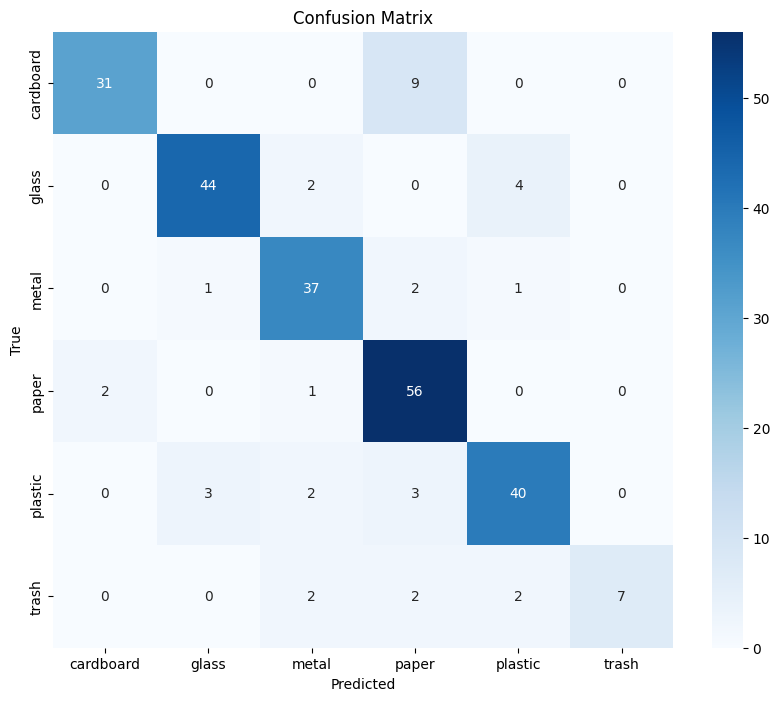

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
cfm = np.around(confusion_matrix(Y_test, y_pred, normalize='true'), decimals=2)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            yticklabels=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred, target_names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']))

              precision    recall  f1-score   support

   cardboard       0.94      0.78      0.85        40
       glass       0.92      0.88      0.90        50
       metal       0.84      0.90      0.87        41
       paper       0.78      0.95      0.85        59
     plastic       0.85      0.83      0.84        48
       trash       1.00      0.54      0.70        13

    accuracy                           0.86       251
   macro avg       0.89      0.81      0.84       251
weighted avg       0.87      0.86      0.85       251



## try

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline
#paths to the train, validation and test image datasets
train_path = '/content/drive/MyDrive/text-data/Garbage classification'
valid_path = '/content/drive/MyDrive/text-data/Garbage classification'

IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_batches = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training',seed=42)


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.inception_resnet_v2.preprocess_input  ,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='validation',seed=42)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [ ]:
# Training set
num_train_batches = len(train_batches)
X_train, Y_train = [], []

for i in range(num_train_batches):
    data = train_batches.next()
    X_train.append(data[0])
    Y_train.append(data[1])

X_train = np.concatenate(X_train)
Y_train = np.concatenate(Y_train)

# Validation set
num_valid_batches = len(valid_batches)
X_test, Y_test = [], []

for i in range(num_valid_batches):
    data = valid_batches.next()
    X_test.append(data[0])
    Y_test.append(data[1])

X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)


In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.Xception(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_output1=base_model.get_layer('add_11').output
#inp= model_mobileNet.layers[-4].output
out=tf.keras.layers.GlobalAveragePooling2D()(base_output1)
model = tf.keras.models.Model(inputs=base_model.input, outputs=out)

# Extract features using the pre-trained model
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

8/8 [==============================] - 3s 430ms/step


In [ ]:
X_train_features.shape

(2276, 1024)

In [ ]:

# Flatten the extracted features
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)
X_train =X_train_features
X_test = X_test_features

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [ ]:
Y_train=np.argmax(Y_train, axis=1)
Y_test=np.argmax(Y_test, axis=1)

In [ ]:
# Train SVM classifier with selected features
clf = SVC()
clf.fit(X_train_features, Y_train)

y_pred = clf.predict(X_train_features)
accuracy = accuracy_score(Y_train, y_pred)

print("Accuracy on Train Set:", accuracy)
# Evaluate on the test set
y_pred = clf.predict(X_test_features)
accuracy = accuracy_score(Y_test, y_pred)

print("Accuracy on Test Set:", accuracy)

Accuracy on Train Set: 0.9569420035149385
Accuracy on Test Set: 0.8844621513944223


In [ ]:
class GeneticAlgorithm:
    def __init__(self, population_size, n_features, crossover_prob=0.8, mutation_prob=0.2, generations=6):
        self.population_size = population_size
        self.n_features = n_features
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.generations = generations

    def initialize_population(self):
        return np.random.randint(2, size=(self.population_size, self.n_features))

    def evaluate_population(self, population, X_train, y_train):
        accuracies = []
        for solution in population:
            selected_features = np.where(solution == 1)[0]
            if len(selected_features) == 0:
                accuracies.append(0.0)
                continue

            clf = SVC()
            clf.fit(X_train[:, selected_features], y_train)
            accuracy = accuracy_score(y_train, clf.predict(X_train[:, selected_features]))
            accuracies.append(accuracy)

        return np.array(accuracies)

    def select_parents(self, population, fitness):
        # Tournament selection
        selected_indices = np.random.choice(self.population_size, size=(2, self.population_size), replace=True)
        selected_parents = population[selected_indices[np.argmax(fitness[selected_indices], axis=0), np.arange(self.population_size)]]
        return selected_parents

    def crossover(self, parent1, parent2):
        # Single-point crossover
        crossover_point = np.random.randint(1, self.n_features)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2

    def mutate(self, child):
        # Bit-flip mutation
        mutation_mask = np.random.rand(self.n_features) < self.mutation_prob
        child[mutation_mask] = 1 - child[mutation_mask]
        return child

    def run(self, X_train, y_train):
        population = self.initialize_population()

        for generation in range(self.generations):
            fitness = self.evaluate_population(population, X_train, y_train)

            # Select parents
            parents = self.select_parents(population, fitness)

            # Create offspring through crossover so we get the new population
            offspring = []
            for i in range(0, self.population_size, 2):
                if np.random.rand() < self.crossover_prob:
                    child1, child2 = self.crossover(parents[i], parents[i + 1])
                else:
                    child1, child2 = parents[i], parents[i + 1]

                # Mutate children for the new generation
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                offspring.append(child1)
                offspring.append(child2)

            population[:self.population_size] = np.array(offspring)

        # Select the best solution from the final population
        final_fitness = self.evaluate_population(population, X_train, y_train)
        best_solution = population[np.argmax(final_fitness)]

        return best_solution


population_size = 20

ga = GeneticAlgorithm(population_size=population_size, n_features=X_train.shape[1])
selected_features = ga.run(X_train, Y_train)

# Train SVM classifier with selected features
clf = SVC()
clf.fit(X_train[:, selected_features == 1], Y_train)

# Evaluate on the test set
y_pred = clf.predict(X_test[:, selected_features == 1])
accuracy = accuracy_score(Y_test, y_pred)

print("Selected Features:", np.where(selected_features == 1)[0])
print("Accuracy on Test Set:", accuracy)

Selected Features: [   0    1    2    5    8   10   12   14   17   19   21   23   25   27
   30   33   34   35   36   39   40   42   46   49   51   52   53   54
   60   61   63   66   67   68   72   78   83   89   90   91   93   97
   99  103  104  110  112  114  115  122  123  124  125  126  128  129
  130  134  140  141  142  149  150  151  153  157  159  163  164  165
  166  169  172  173  178  179  180  181  183  188  190  192  194  196
  197  199  200  204  206  209  211  215  218  219  220  221  223  228
  230  231  232  233  234  237  238  241  244  248  249  250  251  252
  255  256  258  261  263  264  267  274  275  276  277  279  280  281
  283  284  286  287  288  289  290  291  296  300  301  303  304  306
  308  309  314  315  316  318  322  323  324  325  327  329  330  333
  334  338  339  340  341  342  344  345  346  348  350  351  352  355
  356  358  359  361  362  363  364  367  368  370  371  372  375  376
  380  383  386  387  388  393  394  395  396  399  400  4

In [ ]:
X_train[:, selected_features == 1].shape

(2276, 499)

In [ ]:
y_pred_train = clf.predict(X_train[:, selected_features == 1])
accuracy = accuracy_score(Y_train, y_pred_train)

print("Accuracy on Train Set:", accuracy)

Accuracy on Train Set: 0.9560632688927944


In [ ]:
# Evaluate the model and print the confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Compute the confusion matrix
confusion_mat = confusion_matrix(Y_test, y_pred)
#print("Confusion Matrix:")
print(confusion_mat)

precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

[[33  0  0  7  0  0]
 [ 0 44  1  2  3  0]
 [ 0  2 36  2  1  0]
 [ 2  1  0 56  0  0]
 [ 0  1  3  0 44  0]
 [ 0  0  2  0  2  9]]
Precision: 0.8894179642481955
Recall: 0.8844621513944223
F1-score: 0.8838528810400361


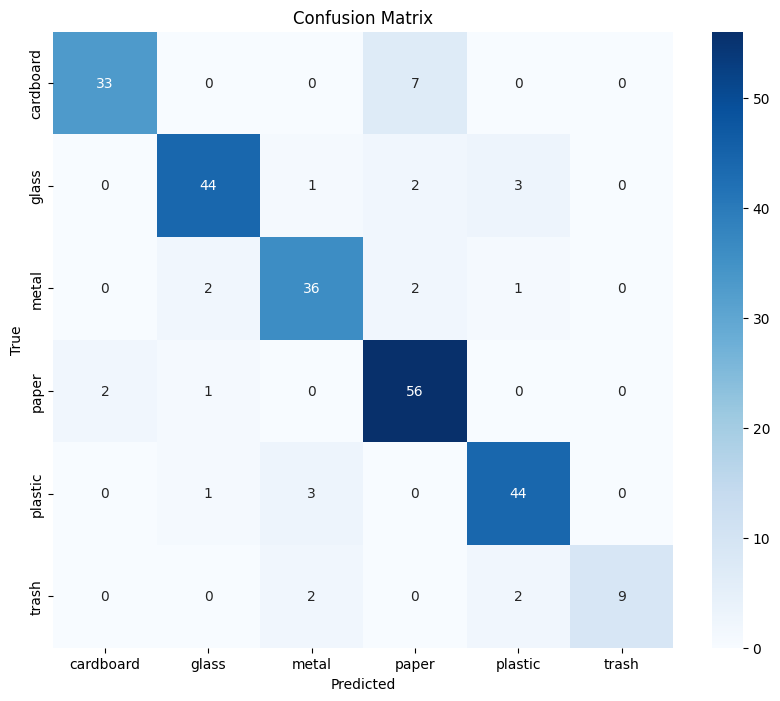

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
cfm = np.around(confusion_matrix(Y_test, y_pred, normalize='true'), decimals=2)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            yticklabels=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred, target_names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']))

              precision    recall  f1-score   support

   cardboard       0.94      0.82      0.88        40
       glass       0.92      0.88      0.90        50
       metal       0.86      0.88      0.87        41
       paper       0.84      0.95      0.89        59
     plastic       0.88      0.92      0.90        48
       trash       1.00      0.69      0.82        13

    accuracy                           0.88       251
   macro avg       0.91      0.86      0.88       251
weighted avg       0.89      0.88      0.88       251

